### `simulation.ipynb`
----------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import langevin.langevin as lg
import langevin.files as fs
import importlib
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

sim = lg.Langevin3D()

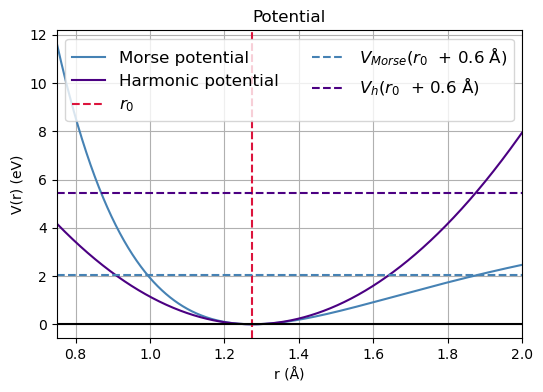

In [2]:
importlib.reload(fs)
rv = np.linspace(0.75, 2., 1000)
pv = sim.potential_morse(rv)
hv = sim.potential_harmonic(rv)
offset = 0.6

plt.figure(figsize=(6, 4))
plt.plot(rv, pv, label='Morse potential', color='steelblue')
plt.plot(rv, hv, label='Harmonic potential', color='indigo')
plt.grid(True)
plt.axvline(sim.r_0, color='crimson', lw=1.5, ls='--', label=r'$r_0$')
plt.axhline(0, color='black', lw=1.5)
plt.axhline(sim.potential_morse(sim.r_0+offset), color='steelblue', lw=1.5, ls='--', label=r'$V_{Morse}(r_0$ ' f' + {offset} Å)')
plt.axhline(sim.potential_harmonic(sim.r_0+offset), color='indigo', lw=1.5, ls='--', label=r'$V_{h}(r_0$ ' f' + {offset} Å)')
plt.xlabel(r"r (Å)")
plt.ylabel("V(r) (eV)")
plt.title("Potential")
plt.legend(loc='upper center', fontsize=12, ncols=2)
plt.xlim(0.75, 2)
plt.savefig(fs.get_media_dir() / 'morse_vs_harmonic_potential.png', dpi=300)

## 3D molecular dynamics with no thermostat
------------------------------------------

Simulation with morse potential loaded from /mnt/c/Cours CS/msn/md-langevin/simulations/mode_langevin_pot_morse_gamma_500e9_TNone_seed_5_dt1.0e-16_r_init_1.875A.npz
Simulation with harmonic potential loaded from /mnt/c/Cours CS/msn/md-langevin/simulations/mode_langevin_pot_harmonic_gamma_500e9_TNone_seed_5_dt1.0e-16_r_init_1.875A.npz


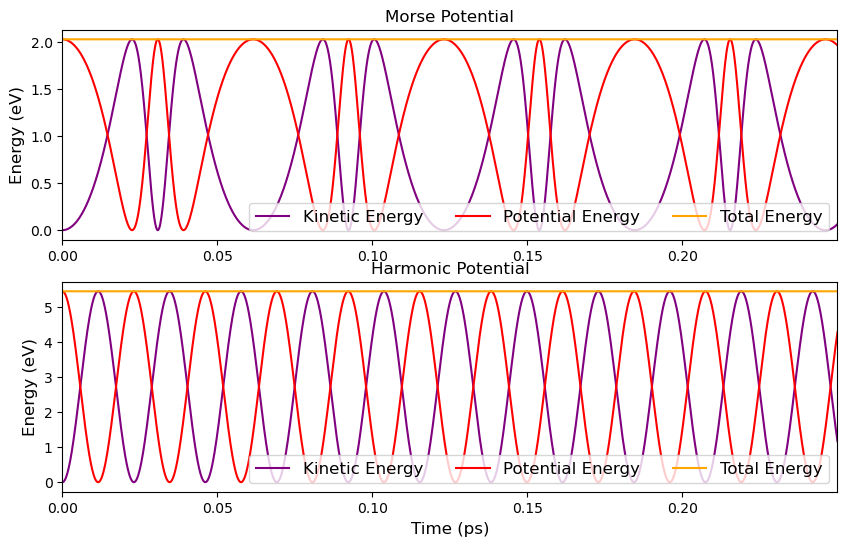

In [ ]:
## Comparing with no thermostat the energies and temperature evolution with a harmonic potential vs Morse potential
for potential_type in ['morse', 'harmonic']:
    T = None # no thermostat
    dt = 1e-16
    gamma = 5e11 # does not matter here since we have no thermostat
    seed = 5
    mode = 'langevin'
    r_init = sim.r_0 + 0.6
    sim = lg.Langevin3D(seed=seed, T=None, dt=dt, potential=potential_type, gamma=gamma)
    filename = fs.get_simulations_dir() / f'mode_{mode}_pot_{potential_type}_gamma_{int(gamma/1e9)}e9_T{T}_seed_{seed}_dt{dt*1e16}e-16_r_init_{r_init}A.npz'
    if filename.with_suffix('.npz').exists() and not overwrite:
        sim, data = lg.Langevin3D.load_from_file(filename)
        print(f'Simulation with {potential_type} potential loaded from {filename}')
        continue
    data, run_opt = sim.run(
        n_steps=1e4, r_init=r_init, mode='langevin', do_byproducts=True, filename=filename
        )
    print(f'Simulation with {potential_type} potential done and saved to {filename}')

## plot both potential types
fig, axs = plt.subplots(nrows=2, figsize=(10, 6))
for ax, potential_type in zip(axs, ['morse', 'harmonic']):
    filename = fs.get_simulations_dir() / f'mode_{mode}_pot_{potential_type}_gamma_{int(gamma/1e9)}e9_T{T}_seed_{seed}_dt{dt*1e16}e-16_r_init_{r_init}A.npz'
    sim, data = lg.Langevin3D.load_from_file(filename)
    
    time_ps = data['time'] * 1e12
    kinetic_e_H = data['kinetic_energy_H']
    kinetic_e_Cl = data['kinetic_energy_Cl']
    potential_e = data['potential_energy']
    kinetic_e = kinetic_e_H + kinetic_e_Cl
    mec_e = kinetic_e + potential_e

    ax.plot(time_ps, kinetic_e, label=f'Kinetic Energy', color='purple')
    ax.plot(time_ps, potential_e, label=f'Potential Energy', color='red')
    ax.plot(time_ps, mec_e, label=f'Total Energy', color='orange')
    ax.set_xlim(0, time_ps[-1]*0.25)
    ax.legend(loc='lower right', fontsize=12, ncols=3)
    ax.set_ylabel('Energy (eV)', fontsize=12)
axs[0].set_title('Morse Potential')
axs[1].set_title('Harmonic Potential')
axs[1].set_xlabel('Time (ps)', fontsize=12)
plt.savefig(fs.get_media_dir() / 'energies_comparison_morse_harmonic.png', dpi=300)


### Adding the thermostat
---------------------------

In [ ]:
importlib.reload(lg)
T = 500  # K
dt = 2e-15 # s
gamma = 5e11  # 1/s
potential_type = 'morse'
seed = 5
mode = 'langevin'
r_init = sim.r_0
filename = fs.get_simulations_dir() / f'mode_{mode}_pot_{potential_type}_gamma_{int(gamma/1e9)}e9_T{T}_seed_{seed}_dt{dt*1e16}e-16_r_init_{r_init}A.npz'
overwrite = False
if not filename.with_suffix('.npz').exists() or overwrite:
    sim = lg.Langevin3D(seed=seed, T=T, dt=dt, potential=potential_type, gamma=gamma)
    data, run_opt = sim.run(
        n_steps=5e4, r_init=r_init, mode='langevin', do_byproducts=True, filename=filename
        )
else:
    sim, data = lg.Langevin3D.load_from_file(filename)

Text(0, 0.5, 'Molecular bond length (Å)')

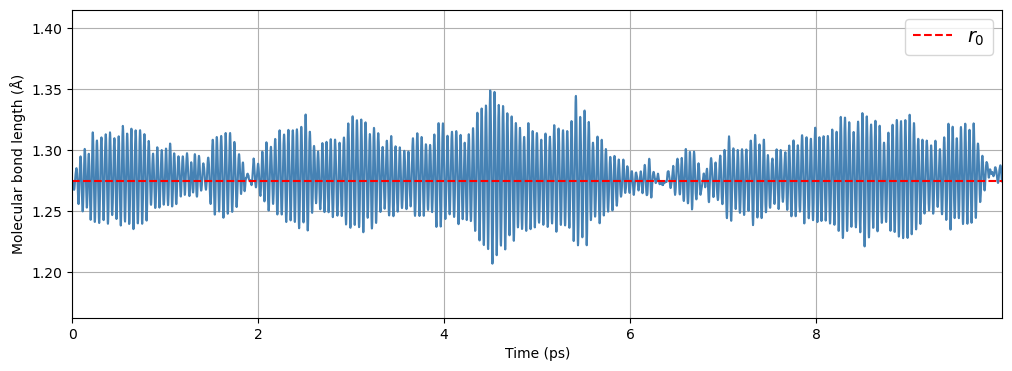

In [64]:
time = data['time']
time_ps = time * 1e12
plt.figure(figsize=(12, 4))
plt.plot(time_ps, np.sqrt(np.sum((data['r_H']-data['r_Cl'])**2, axis=1)), color='steelblue')
plt.axhline(sim.r_0, ls='--', color='red', label=r'$r_0$')
plt.xlim(0, time_ps[-1]*0.1)
plt.grid()
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('Time (ps)')
plt.ylabel('Molecular bond length (Å)')

(0.0, 99.99800000000002)

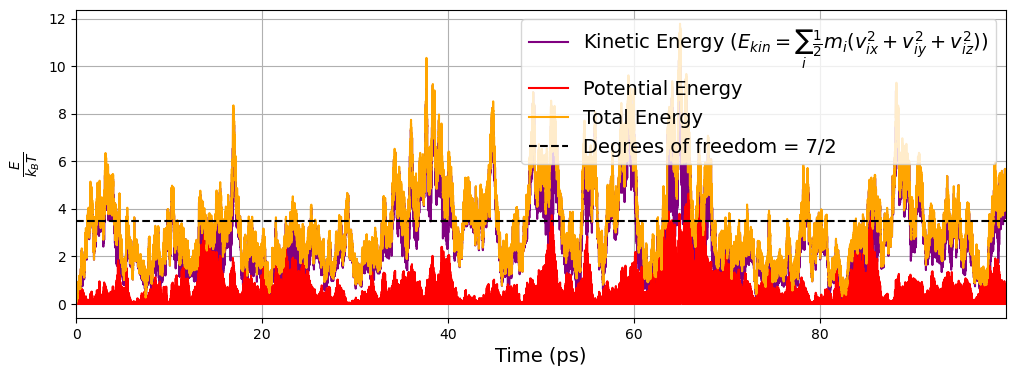

In [86]:
## energy plot
plt.figure(figsize=(12, 4))
time = data['time']
kinetic_e_H = data['kinetic_energy_H']
kinetic_e_Cl = data['kinetic_energy_Cl']
kinetic_e = kinetic_e_H + kinetic_e_Cl

potential_e = data['potential_energy']

mec_e = kinetic_e + potential_e
temperature = sim.temperature(energy=mec_e, temp_window=25000)
norm = sim.k_B * T #temperature if T is not None else 1

time_ps = time * 1e12
kin_label = r'$(E_{kin}=\sum_i \frac{1}{2}m_i(v_{ix}^2+v_{iy}^2+v_{iz}^2))$'
plt.plot(time_ps, (kinetic_e_H + kinetic_e_Cl) / norm, label='Kinetic Energy ' + kin_label , color='purple')
plt.plot(time_ps, potential_e / norm, label='Potential Energy', color='red')
plt.plot(time_ps, mec_e / norm, label='Total Energy', color='orange')
plt.axhline(7/2, ls='--', color='black', label='Degrees of freedom = 7/2')
#plt.plot(time_ps, mec_e / norm, label='Total Energy', color='orange')
#plt.plot(time_ps, temperature * sim.k_B / norm, color='blue')
plt.grid()
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('Time (ps)', fontsize=14)
plt.ylabel(r'$\frac{E}{k_B T}$', fontsize=14)
plt.xlim(0, time_ps[-1])
#plt.plot(time, potential_e, label='Potential Energy', color='green')

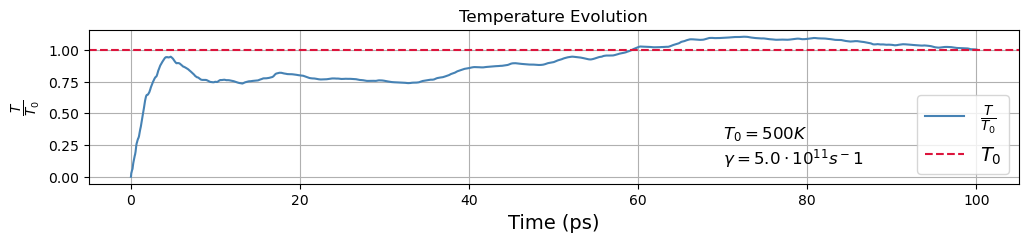

In [91]:
plt.figure(figsize=(12, 2))
plt.plot(time_ps, temperature / sim.T, label=r'$\frac{T}{T_0}$', color='steelblue')
plt.axhline(1, ls='--', color='crimson', label='$T_0$')
plt.xlabel('Time (ps)', fontsize=14)
plt.ylabel(r'$\frac{T}{T_0}$', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.text(0.7*time_ps[-1], 0.1, f'$T_0 = {sim.T} K$\n$\gamma = {sim.gamma/1e11:<.1f} \cdot 10^{{11}} s^{-1}$', fontsize=12)
plt.grid(True)
plt.title('Temperature Evolution')
plt.savefig(fs.get_media_dir() / 'energy_temperature_evolution.png', dpi=300)

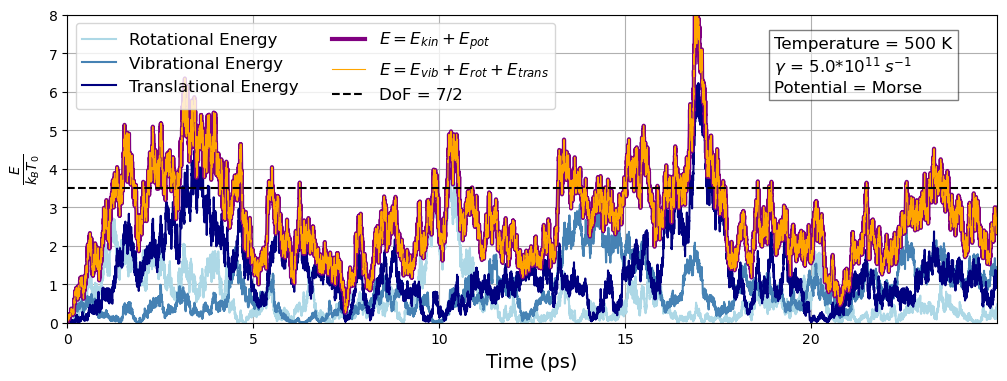

In [ ]:
time = data['time']
time_ps = time * 1e12
kinetic_e = data['kinetic_energy_H'] + data['kinetic_energy_Cl']
potential_e = data['potential_energy']
rotation_energy = sim.rotation_energy(
    data['r_H'], data['r_Cl'], data['v_H'], data['v_Cl']
)
translation_energy = sim.translation_energy(
    data['r_H'], data['r_Cl'], data['v_H'], data['v_Cl']
)
vibration_energy = sim.vibration_energy(
    data['r_H'], data['r_Cl'], data['v_H'], data['v_Cl']
) + potential_e
modes_e = rotation_energy + vibration_energy + translation_energy
mec_e = kinetic_e + potential_e
plt.figure(figsize=(12, 4))
plt.plot(time_ps, rotation_energy / norm, label='Rotational Energy', color='lightblue')
plt.plot(time_ps, vibration_energy / norm, label='Vibrational Energy', color='steelblue')
plt.plot(time_ps, translation_energy / norm, label='Translational Energy', color='navy')
plt.plot(time_ps, mec_e / norm, label=r'$E=E_{kin} + E_{pot}$', color='purple', linewidth=3)
plt.plot(time_ps, modes_e / norm, label=r'$E=E_{vib}+E_{rot}+E_{trans}$', linestyle='-', color='orange', linewidth=0.8)
plt.axhline(7/2, ls='--', color='black', label='DoF = 7/2')

plt.text(
    0.19*time_ps[-1], 
    6, 
    f'Temperature = {T} K\n' f'$\gamma$ = {gamma/1e11:.1f}*$10^{{11}}\;s^{{-1}}$\n' f'{potential_type.capitalize()} potential', 
    bbox=dict(facecolor='white', alpha=0.5), 
    fontsize=12
    )

plt.ylabel(r'$\frac{E}{k_B T_0}$', fontsize=14)
plt.xlabel('Time (ps)', fontsize=14)
plt.xlim(0, 0.25*time_ps[-1])
plt.ylim(0, 8)
plt.legend(loc='upper left', fontsize=12, ncols=2)
plt.grid()
plt.savefig(fs.get_media_dir() / 'energy_modes_decomposition.png', dpi=300)

Text(0.5, 0.92, '3D Trajectory of H-Cl')

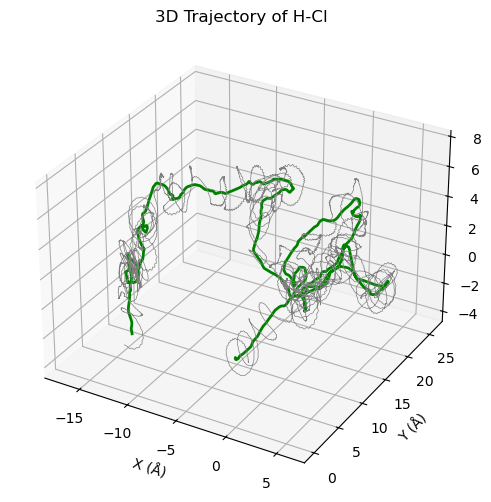

In [436]:
## 3D position of r_Cl, r_H over time
r_cl = data['r_Cl']
r_h = data['r_H']
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(r_cl[:, 0], r_cl[:, 1], r_cl[:, 2], color='green', label='Cl', linewidth=2)
ax.plot(r_h[:, 0], r_h[:, 1], r_h[:, 2], color='gray', linewidth=0.5, label='H')

ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title('3D Trajectory of H-Cl')

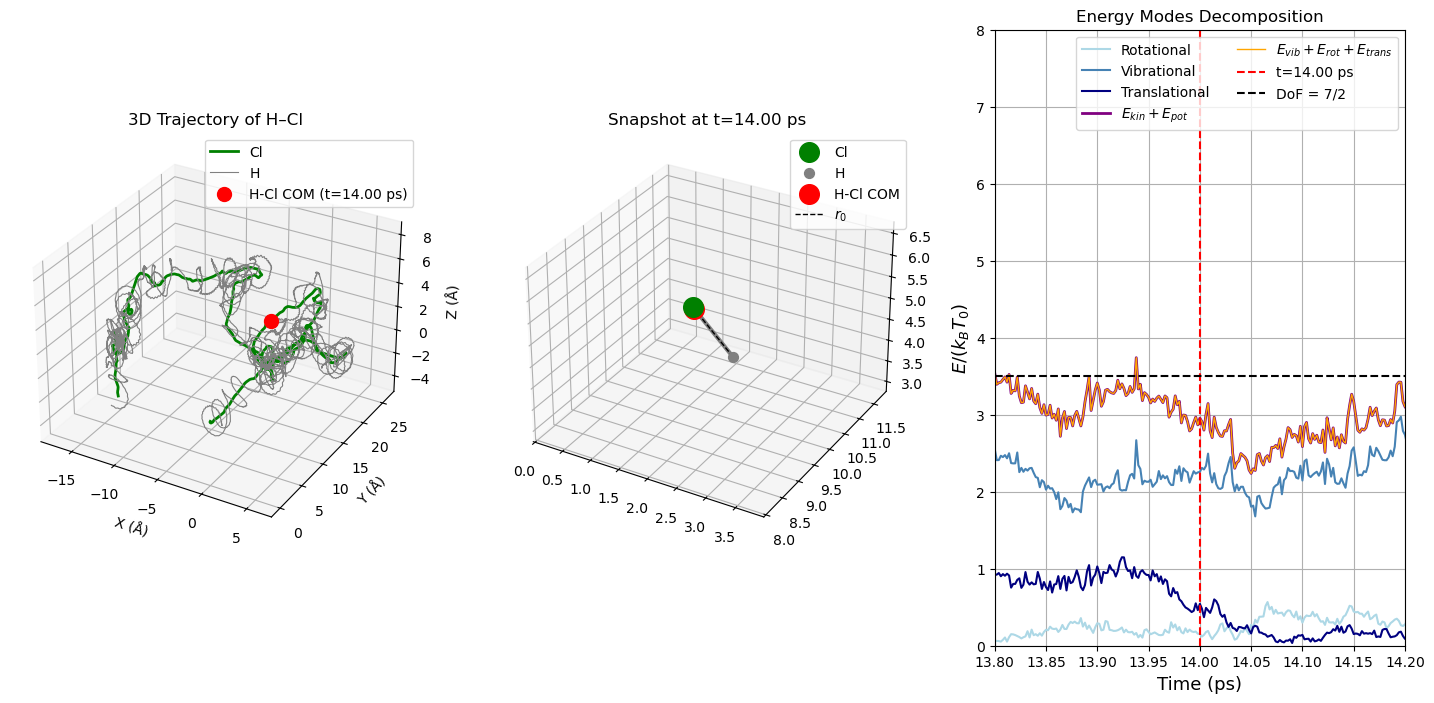

In [130]:
file = fs.get_simulations_dir() / f'mode_langevin_pot_morse_gamma_500e9_T500_seed_5_dt20.0e-16_r_init_1.275A.npz'
sim, data = lg.Langevin3D.load_from_file(file)
frame_idx = 7000

r_cl = data['r_Cl']
r_h = data['r_H']
time = data['time']
time_ps = time * 1e12
time_frame = time_ps[frame_idx]

kinetic_e = data['kinetic_energy_H'] + data['kinetic_energy_Cl']
potential_e = data['potential_energy']
rotation_energy = sim.rotation_energy(data['r_H'], data['r_Cl'], data['v_H'], data['v_Cl'])
translation_energy = sim.translation_energy(data['r_H'], data['r_Cl'], data['v_H'], data['v_Cl'])
vibration_energy = sim.vibration_energy(data['r_H'], data['r_Cl'], data['v_H'], data['v_Cl']) + potential_e
modes_e = rotation_energy + vibration_energy + translation_energy
mec_e = kinetic_e + potential_e

fig = plt.figure(figsize=(18, 8))

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(r_cl[:, 0], r_cl[:, 1], r_cl[:, 2], color='green', label='Cl', linewidth=2)
ax1.plot(r_h[:, 0], r_h[:, 1], r_h[:, 2], color='gray', linewidth=0.8, label='H')
r_cm = (sim.m_H * r_h + sim.m_Cl * r_cl) / (sim.m_H + sim.m_Cl)
ax1.scatter(r_cm[frame_idx, 0], r_cm[frame_idx, 1], r_cm[frame_idx, 2], color='red', s=100, label=f'H-Cl COM (t={time_frame:.2f} ps)')
ax1.set_xlabel('X (Å)')
ax1.set_ylabel('Y (Å)')
ax1.set_zlabel('Z (Å)')
ax1.set_title('3D Trajectory of H–Cl')
ax1.legend()

ax2 = fig.add_subplot(132, projection='3d')
r_cl_f = r_cl[frame_idx]
r_h_f = r_h[frame_idx]
r_cm_f = r_cm[frame_idx]
ax2.scatter(*r_cl_f, color='green', s=200, label='Cl')
ax2.scatter(*r_h_f, color='gray', s=50, label='H')
ax2.scatter(*r_cm_f, color='red', s=200, label='H-Cl COM')
ax2.plot(
    [r_cl_f[0], r_h_f[0]],
    [r_cl_f[1], r_h_f[1]],
    [r_cl_f[2], r_h_f[2]],
    color='gray', linewidth=3
)
unit_dir = (r_h_f - r_cl_f) / np.linalg.norm(r_h_f - r_cl_f)
r_cl_to_r0 = r_cl_f + unit_dir * sim.r_0
ax2.plot(
    [r_cl_f[0], r_cl_to_r0[0]],
    [r_cl_f[1], r_cl_to_r0[1]],
    [r_cl_f[2], r_cl_to_r0[2]],
    color='black', linestyle='--', label=r'$r_0$', linewidth=1
)
midpoint = (r_cl_f + r_h_f) / 2
extent = 2.0
ax2.set_xlim(midpoint[0] - extent, midpoint[0] + extent)
ax2.set_ylim(midpoint[1] - extent, midpoint[1] + extent)
ax2.set_zlim(midpoint[2] - extent, midpoint[2] + extent)
ax2.set_title(f'Snapshot at t={time_frame:.2f} ps')
ax1.set_xlabel('X (Å)')
ax1.set_ylabel('Y (Å)')
ax1.set_zlabel('Z (Å)')
ax2.legend()

ax3 = fig.add_subplot(133)
norm = sim.k_B * T
ax3.plot(time_ps, rotation_energy / norm, label='Rotational', color='lightblue')
ax3.plot(time_ps, vibration_energy / norm, label='Vibrational', color='steelblue')
ax3.plot(time_ps, translation_energy / norm, label='Translational', color='navy')
ax3.plot(time_ps, mec_e / norm, label=r'$E_{kin}+E_{pot}$', color='purple', linewidth=2)
ax3.plot(time_ps, modes_e / norm, label=r'$E_{vib}+E_{rot}+E_{trans}$', color='orange', linewidth=1)

ax3.axvline(time_ps[frame_idx], color='red', linestyle='--', label=f't={time_frame:.2f} ps')

ax3.axhline(7/2, ls='--', color='black', label='DoF = 7/2')
ax3.set_ylabel(r'$E / (k_B T_0)$', fontsize=13)
ax3.set_xlabel('Time (ps)', fontsize=13)
ax3.set_xlim(time_ps[frame_idx] - 0.2, time_ps[frame_idx] + 0.2)
ax3.set_ylim(0, 8)
ax3.grid(True)
ax3.legend(fontsize=10, ncols=2)
ax3.set_title('Energy Modes Decomposition')

plt.savefig(fs.get_media_dir() / 'composite_simulation_figure.png', dpi=300)


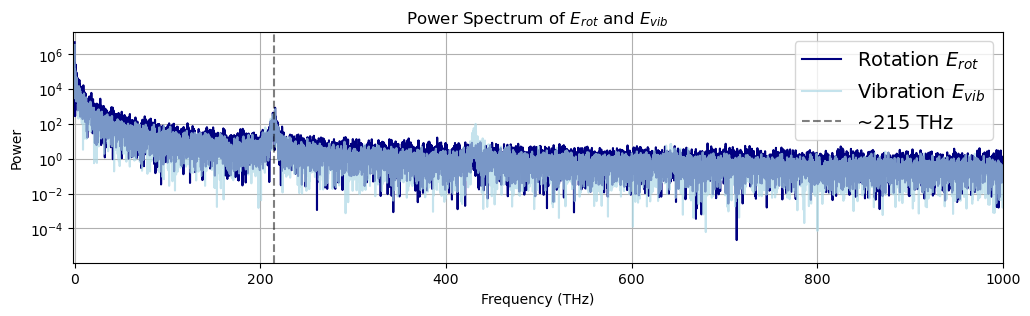

In [155]:
## rotation - vibration coupling study over time
## do fft of rotation and vibration energies
sim, data = lg.Langevin3D.load_from_file(file)
e_rot = sim.rotation_energy(data['r_H'], data['r_Cl'], data['v_H'], data['v_Cl'])
e_vib = sim.vibration_energy(data['r_H'], data['r_Cl'], data['v_H'], data['v_Cl']) + data['potential_energy']

from scipy.fft import fft, fftfreq

N = len(e_rot)
dt = 2e-16

freq = fftfreq(N, dt) * 1e-12  # in THz
rot_fft = fft(e_rot)
vib_fft = fft(e_vib)

plt.figure(figsize=(12,3))
plt.plot(freq[:N//2], np.abs(rot_fft[:N//2])**2, label='Rotation $E_{rot}$', color='navy')
plt.plot(freq[:N//2], np.abs(vib_fft[:N//2])**2, label='Vibration $E_{vib}$', color='lightblue', alpha=0.7)
plt.axvline(215, ls='--', color='black', label='~215 THz', alpha=0.5, linestyle='--')
plt.xlabel('Frequency (THz)')
plt.ylabel('Power')
plt.legend(fontsize=14)
plt.title('Power Spectrum of $E_{rot}$ and $E_{vib}$')
plt.xlim(-2, 1000)
plt.yscale('log')
plt.grid(True)
plt.savefig(fs.get_media_dir() / 'rotation_vibration_power_spectrum.png')

In [95]:
## generate all the simulations
importlib.reload(lg)
dataset = {
    "morse": [],
    "harmonic": []
}
for potential_type in ['morse', 'harmonic']:
    for gamma in [3e11, 5e11, 8e11, 1e12]:
        T = 500  # K
        dt = 2e-15 # s
        seed = 5
        mode = 'langevin'
        r_init = sim.r_0
        filename = fs.get_simulations_dir() / f'mode_{mode}_pot_{potential_type}_gamma_{int(gamma/1e9)}e9_T{T}_seed_{seed}_dt{dt*1e16}e-16_r_init_{r_init}A.npz'
        overwrite = False
        if not filename.with_suffix('.npz').exists() or overwrite:
            sim = lg.Langevin3D(seed=seed, T=T, dt=dt, potential=potential_type, gamma=gamma)
            data, run_opt = sim.run(
                n_steps=5e4, r_init=r_init, mode='langevin', do_byproducts=True, filename=filename
                )
        else:
            sim, data = lg.Langevin3D.load_from_file(filename)
        dataset[potential_type].append((gamma, sim, data))
        print(f'Simulation with {potential_type} potential and gamma={gamma} done and saved to {filename}')

Simulation with morse potential and gamma=300000000000.0 done and saved to /mnt/c/Cours CS/msn/md-langevin/simulations/mode_langevin_pot_morse_gamma_300e9_T500_seed_5_dt20.0e-16_r_init_1.275A.npz
Simulation with morse potential and gamma=500000000000.0 done and saved to /mnt/c/Cours CS/msn/md-langevin/simulations/mode_langevin_pot_morse_gamma_500e9_T500_seed_5_dt20.0e-16_r_init_1.275A.npz
Simulation with morse potential and gamma=800000000000.0 done and saved to /mnt/c/Cours CS/msn/md-langevin/simulations/mode_langevin_pot_morse_gamma_800e9_T500_seed_5_dt20.0e-16_r_init_1.275A.npz
Simulation with morse potential and gamma=1000000000000.0 done and saved to /mnt/c/Cours CS/msn/md-langevin/simulations/mode_langevin_pot_morse_gamma_1000e9_T500_seed_5_dt20.0e-16_r_init_1.275A.npz
Simulation with harmonic potential and gamma=300000000000.0 done and saved to /mnt/c/Cours CS/msn/md-langevin/simulations/mode_langevin_pot_harmonic_gamma_300e9_T500_seed_5_dt20.0e-16_r_init_1.275A.npz
Simulation w

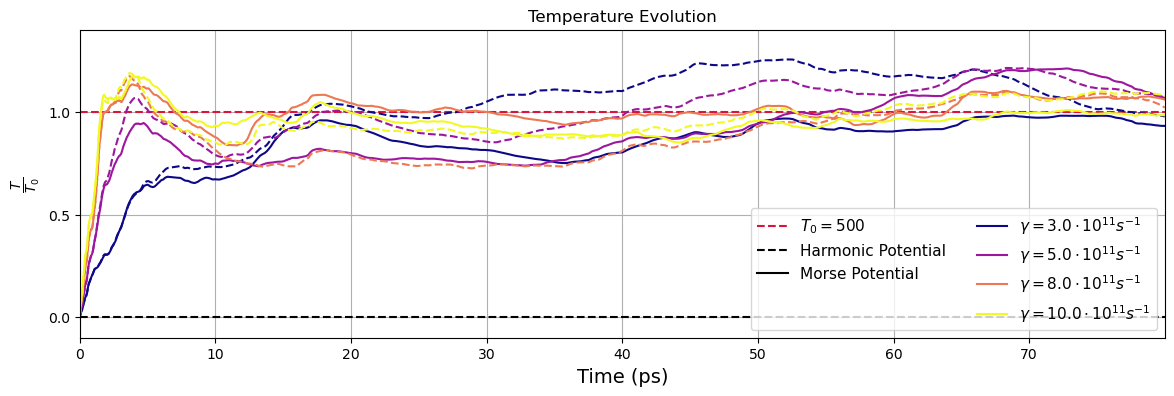

In [124]:
plt.figure(figsize=(14, 4))
colors = plt.get_cmap('plasma')(np.linspace(0, 1, len(dataset['morse'])))
#plt.text(0.7*time_ps[-1], 0.1, f'$T_0 = {sim.T} K$', fontsize=12) #\n$\gamma = {sim.gamma/1e11:<.1f} \cdot 10^{{11}} s^{-1}$
plt.axhline(1, ls='--', color='crimson', label=f'$T_0={sim.T}$')
plt.axhline(0, ls='--', color='black', label='Harmonic Potential')
plt.axhline(-100, ls='-', color='black', label='Morse Potential')

#empty line for legend
plt.plot([], [], ' ', label=' ')
norm = sim.k_B * sim.T
for i in range(len(dataset['morse'])):
    gamma_m, sim_m, data_m = dataset['morse'][i]
    gamma_h, sim_h, data_h = dataset['harmonic'][i]

    time_m = data_m['time']
    time_ps = time_m * 1e12

    kinetic_e_m = data_m['kinetic_energy_H'] + data_m['kinetic_energy_Cl']
    potential_e_m = data_m['potential_energy']
    mec_e_m = kinetic_e_m + potential_e_m
    temperature_m = sim.temperature(energy=mec_e_m, temp_window=20000)

    kinetic_e_h = data_h['kinetic_energy_H'] + data_h['kinetic_energy_Cl']
    potential_e_h = data_h['potential_energy']
    mec_e_h = kinetic_e_h + potential_e_h
    temperature_h = sim.temperature(energy=mec_e_h, temp_window=20000)

    plt.plot(time_ps, temperature_m / sim.T, label=rf'$\gamma={sim_m.gamma/1e11:.1f} \cdot 10^{{11}} s^{{-1}}$', color=colors[i])
    plt.plot(time_ps, temperature_h / sim.T, linestyle='--', color=colors[i])
    chartime = gamma_m/1e12 * time_ps
    chartime = np.clip(chartime, 0, 1)
    chartime[chartime == 1] = np.nan
    #plt.plot(time_ps, chartime, linestyle='--', linewidth=0.9, color=colors[i])
    plt.ylim(-0.1, 1.4)
    plt.xlabel('Time (ps)', fontsize=14)
    plt.yticks([0, 0.5, 1])
    plt.ylabel(r'$\frac{T}{T_0}$', fontsize=14)
    plt.legend(loc='lower right', fontsize=11, ncols=2)
    plt.xlim(0, 0.8*time_ps[-1])
    plt.grid(True)
    plt.title('Temperature Evolution')
    plt.savefig(fs.get_media_dir() / 'energy_temperature_evolution.png', dpi=300)

In [ ]:
requested_frames = [5, 20, 50, 100, 150]
output_dir = fs.get_media_dir() / f'frames_{filename.stem}'
r_H = data['r_H']
r_Cl = data['r_Cl']
if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=True)


N = len(r_Cl)
axis_offset = 0.1

for frame in requested_frames:
    if frame >= N:
        raise ValueError(f"Requested frame {frame} exceeds available frames {N-1}")

    H = r_H[frame]
    Cl = r_Cl[frame]

    fig = plt.figure(figsize=(12,5))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(r_Cl[:,0], r_Cl[:,1], r_Cl[:,2], color='green', linestyle='--', linewidth=2, label='Cl')
    ax1.plot(r_H[:,0],  r_H[:,1],  r_H[:,2], color='lightgray', linestyle='--', linewidth=1.4, label='H')
    ax1.scatter(H[0], H[1], H[2], s=60, c='lightgray', marker='o')
    ax1.scatter(Cl[0], Cl[1], Cl[2], s=100, c='green', marker='o')
    ax1.set_title(f'Trajectory – Frame {frame}')
    ax1.set_xlabel('X (Å)')
    ax1.set_ylabel('Y (Å)')
    ax1.set_zlabel('Z (Å)')
    ax1.legend()

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(H[0], H[1], H[2], s=200, c='lightgray')
    ax2.scatter(Cl[0], Cl[1], Cl[2], s=300, c='green')
    ax2.plot([H[0], Cl[0]], [H[1], Cl[1]], [H[2], Cl[2]], color='gray', linewidth=3)

    ax2.set_title('H–Cl Motion')
    ax2.set_xlabel('X (Å)')
    ax2.set_ylabel('Y (Å)')
    ax2.set_zlabel('Z (Å)')

    ax2.set_xlim([min(r_H[:,0].min(), r_Cl[:,0].min())-axis_offset, max(r_H[:,0].max(), r_Cl[:,0].max())+axis_offset])
    ax2.set_ylim([min(r_H[:,1].min(), r_Cl[:,1].min())-axis_offset, max(r_H[:,1].max(), r_Cl[:,1].max())+axis_offset])
    ax2.set_zlim([min(r_H[:,2].min(), r_Cl[:,2].min())-axis_offset, max(r_H[:,2].max(), r_Cl[:,2].max())+axis_offset])

    file_path = output_dir / f"frame_{frame}.png"
    print(file_path)
    plt.savefig(file_path, dpi=300)
    plt.close()

/mnt/c/Cours CS/msn/md-langevin/media/frames_mode_langevin_pot_morse_gamma_500e9_TNone_seed_5_dt1.0e-16_r_init_1.575A/frame_5.png
/mnt/c/Cours CS/msn/md-langevin/media/frames_mode_langevin_pot_morse_gamma_500e9_TNone_seed_5_dt1.0e-16_r_init_1.575A/frame_20.png
/mnt/c/Cours CS/msn/md-langevin/media/frames_mode_langevin_pot_morse_gamma_500e9_TNone_seed_5_dt1.0e-16_r_init_1.575A/frame_50.png
/mnt/c/Cours CS/msn/md-langevin/media/frames_mode_langevin_pot_morse_gamma_500e9_TNone_seed_5_dt1.0e-16_r_init_1.575A/frame_100.png
/mnt/c/Cours CS/msn/md-langevin/media/frames_mode_langevin_pot_morse_gamma_500e9_TNone_seed_5_dt1.0e-16_r_init_1.575A/frame_150.png


Number of frames: 1000


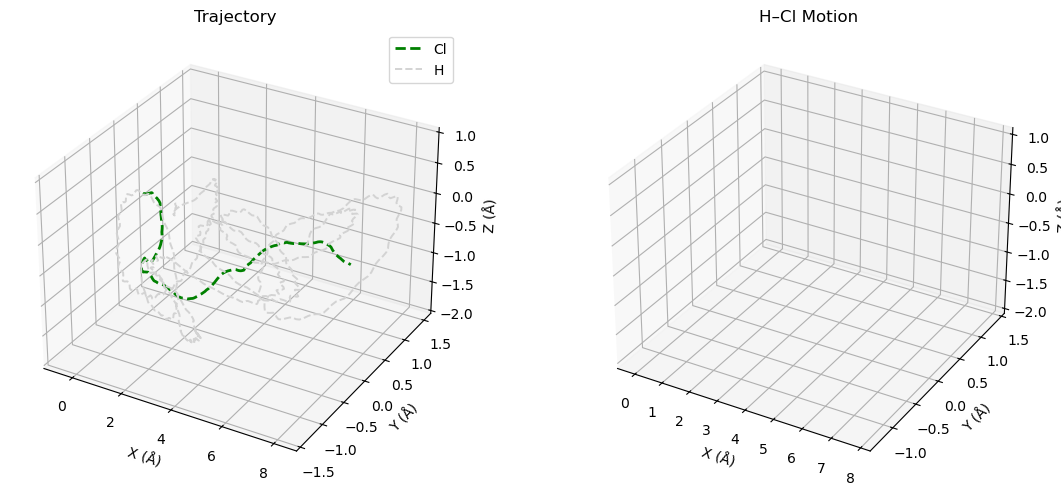

In [15]:
r_Cl = data['r_Cl'][1::40]
r_H = data['r_H'][1::40]

N = len(r_Cl)
print(f"Number of frames: {N}")

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(r_Cl[:,0], r_Cl[:,1], r_Cl[:,2], label='Cl', color='green', linestyle='--', linewidth=2)
ax1.plot(r_H[:,0],  r_H[:,1],  r_H[:,2], label='H', color='lightgray', linestyle='--', linewidth=1.4)
ax1.set_title('Trajectory')
ax1.set_xlabel('X (Å)')
ax1.set_ylabel('Y (Å)')
ax1.set_zlabel('Z (Å)')
ax1.legend()

H_marker = ax1.scatter([], [], [], s=60, c='lightgray', marker='o', label='H (current)')
Cl_marker = ax1.scatter([], [], [], s=100, c='green', marker='o', label='Cl (current)')

ax2 = fig.add_subplot(122, projection='3d')
axis_offset = 0.1
ax2.set_title('H–Cl Motion')
ax2.set_xlim(
    [
        min(np.min(r_H[:,0]), np.min(r_Cl[:,0]))-axis_offset, 
        max(np.max(r_H[:,0]), np.max(r_Cl[:,0]))+axis_offset
    ]
)
ax2.set_ylim(
    [
        min(np.min(r_H[:,1]), np.min(r_Cl[:,1]))-axis_offset, 
        max(np.max(r_H[:,1]), np.max(r_Cl[:,1]))+axis_offset
    ]
)
ax2.set_zlim(
    [
        min(np.min(r_H[:,2]), np.min(r_Cl[:,2]))-axis_offset, 
        max(np.max(r_H[:,2]), np.max(r_Cl[:,2]))+axis_offset
    ]
)
ax2.set_xlabel('X (Å)')
ax2.set_ylabel('Y (Å)')
ax2.set_zlabel('Z (Å)')

H_point = ax2.scatter([], [], [], s=200, c='lightgray')
Cl_point = ax2.scatter([], [], [], s=300, c='green')
bond_line, = ax2.plot([], [], [], color='gray', linewidth=3)

def update(frame):
    H = r_H[frame]
    Cl = r_Cl[frame]

    H_point._offsets3d = ([H[0]], [H[1]], [H[2]])
    Cl_point._offsets3d = ([Cl[0]], [Cl[1]], [Cl[2]])

    bond_line.set_data([H[0], Cl[0]], [H[1], Cl[1]])
    bond_line.set_3d_properties([H[2], Cl[2]])

    H_marker._offsets3d = ([H[0]], [H[1]], [H[2]])
    Cl_marker._offsets3d = ([Cl[0]], [Cl[1]], [Cl[2]])

    return H_point, Cl_point, bond_line, H_marker, Cl_marker

ani = FuncAnimation(fig, update, frames=N, interval=40, blit=False)

plt.tight_layout()
plt.show()

In [21]:
video = fs.get_media_dir() / filename.with_suffix('.gif')
if not video.parent.exists():
    video.parent.mkdir(parents=True, exist_ok=True)
if not video.exists():
    ani.save(video, fps=20, dpi=150)

MovieWriter ffmpeg unavailable; using Pillow instead.


: 